# Práctica 3

## Integrantes del equipo
- Adrián Donate Aguilar
- Javier Carrizosa Bermejo
- Alba Calvo Herrero
- Nicolae Alexandru Molnar

## Enunciado

### 1. Objetivo
Esta práctica consiste en aplicar diversos conceptos vistos relativos al tratamiento y pre-procesado de datos, la selección de métricas de comportamiento y la construcción de modelos de Aprendizaje Automático en un problema de clasificación, de forma que el  alumno  desarrolle  su  capacidad  crítica  a  la  hora  de  emplear y comparar estos modelos.


### 2. Planteamiento
El  alumno  empleará  la base  de  datos elegida en  el último apartado  de  la  práctica entregable  anterior,  referida  a  un  problema  de  diagnóstico  médico  o  un problema similar. En  caso  de  que  el  alumno  desee  cambiar  de  base  de  datos, siempre  en  un contexto similar, podrá hacerlo previa motivación clara de porqué es preciso dicho cambio. Una justificación insuficiente será penalizada.Adicionalmente, el problema debe ser necesariamente uno de clasificación supervisada(es decir, nunca será posible tratar un problema de regresión o no supervisado)


### 3. Tareas a realizar y preguntas
1. Describir brevemente en qué consiste el problema(1 punto, 10 líneas de texto máximo).
2. Sobre el conjunto de datos original proponer algún tratamiento justificado de los datos,alternativas posibles son el escalado de los datos, la compleciónde la base  de  datos para  evitar  desbalanceo  entre  las  clases,  la  eliminación  de observaciones influyentes u otras más complejas como la generación mediante Montecarlo de observaciones subrogadas (2 puntos, 30 líneas de texto).

In [6]:
# Disable warnings
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

# Load data from csv file
data = pd.read_csv('cardiovascular.csv', sep=';')

# print(data.__getattribute__('columns'))
# print(data.head())

print("Data before data processing: ",len(data))

# Filter data transforming string values ('Present', 'Absent') to int values (1, 0)
data['famhist'] = data['famhist'].map({'Present': 1, 'Absent': 0})


# Normalize data
Y = data['chd']
data = data.drop(['chd'], axis=1)

data = (data - data.mean()) / data.std()

# Append chd column to data
data['chd'] = Y

# Detect outliers with Z-score
threshold = 3
z = np.abs(stats.zscore(data))
data_outliers = z[(z > threshold).any(axis=1)]

# Remove outliers
data = data[(z < threshold).all(axis=1)]

# Class balance
data_chd_0 = data[data['chd'] == data['chd'].min()]
data_chd_1 = data[data['chd'] == data['chd'].max()]

# Add new observations to balance dataset
diff = len(data_chd_0) - len(data_chd_1)
if (diff > 0):
    data = data.append(data_chd_1.sample(n=diff, replace=True))
else:
    data = data.append(data_chd_0.sample(n=abs(diff), replace=True))

data_chd_0 = data[data['chd'] == data['chd'].min()]
data_chd_1 = data[data['chd'] == data['chd'].max()]

print("Data after data processing: ",len(data))

# Divide data into X and Y
X = data.drop(['chd'], axis=1)
Y = data['chd']

Data before data processing:  462
Data after data processing:  572


3. Dividir la nueva base de datos generada considerando algún criterio razonable en tres conjuntos: entrenamiento, test y validación y motivar dicha división. En el resto de la práctica, en lo relativo a la selección de modelos óptimos, nuNca se emplearán los conjuntos de test y validación. (1 punto, 10 líneas de texto máximo)

In [9]:
# Divide data set into train, test and validation sets
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
X_test, X_val, Y_test, Y_val = train_test_split(X_test, Y_test, test_size=0.5, random_state=42)

4. Seleccionar,  empleando exclusivamente  el  conjunto de  entrenamientolos modelos óptimos para cada uno de los modelos siguientes, los hiper parámetros a considerar aparecen entre paréntesis: k-nn(número de vecinos), Bayes naïve (parámetro de suavizado), árboles de clasificación (profundidad delárbol)y redes alimentadas hacia delante de(número de capas -máximo 3-y número de neuronas  por  capa).Para  dicha  selección  se  aplicará  necesariamente algún procedimientode re-muestreo como validación cruzada(2 puntos, 20 líneas máximo).

In [10]:
#### Create a KNN classifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

# Find the best k value using GridSearchCV
k_range = range(1, 31)

knn = KNeighborsClassifier()
knn = GridSearchCV(knn, param_grid={'n_neighbors': k_range}, cv=10, scoring='accuracy')

knn.fit(X_train, Y_train)

print("Successfully trained KNN classifier with k = ", knn.best_params_['n_neighbors'])
print("Best score: ", knn.best_score_*100,"%")


Successfully trained KNN classifier with k =  1
Best score:  74.44444444444443 %


In [11]:
# Tree classifier
from sklearn.tree import DecisionTreeClassifier

# Find the best max_depth value using GridSearchCV
max_depth_range = range(1, 31)

tree = DecisionTreeClassifier(criterion='entropy', random_state=2)
tree = GridSearchCV(tree, param_grid={'max_depth': max_depth_range}, cv=10, scoring='accuracy')

tree.fit(X_train, Y_train)

print("Successfully trained Decision Tree classifier with max_depth = ", tree.best_params_['max_depth'])
print("Best score: ", tree.best_score_*100,"%")

Successfully trained Decision Tree classifier with max_depth =  18
Best score:  76.6231884057971 %


In [12]:
# Naïve Bayes classifier
from sklearn.naive_bayes import GaussianNB

# Find the best var_smoothing value using GridSearchCV
# Range of values: 1*10**-9 to 1*10**-3
var_smoothing_range = np.logspace(-9, -3, num=10)
bayes = GaussianNB()
bayes = GridSearchCV(bayes, param_grid={'var_smoothing': var_smoothing_range}, cv=10, scoring='accuracy')

bayes.fit(X_train, Y_train)

print("Successfully trained Naive Bayes classifier with var_smoothing = ", bayes.best_params_['var_smoothing'])
print("Best score: ", bayes.best_score_*100,"%")

Successfully trained Naive Bayes classifier with var_smoothing =  1e-09
Best score:  68.69565217391305 %


In [13]:
# FeedForward Neural Network classifier with keras
from sklearn.neural_network import MLPClassifier

# Create model
ann = MLPClassifier(random_state=2)

# Find the best hidden_layer_sizes value using GridSearchCV
hidden_layer_sizes_range = []

for neuron in range(1, 31):
    hidden_layer_sizes_range.append((neuron,))

for neuron in range(1, 31):
    for neuron2 in range(1,31):
        hidden_layer_sizes_range.append((neuron, neuron2))

for neuron in range(1,31):
    for neuron2 in range(1,31):
        for neuron3 in range(1,31):
            hidden_layer_sizes_range.append((neuron, neuron2, neuron3))

ann = GridSearchCV(ann, param_grid={'hidden_layer_sizes': hidden_layer_sizes_range}, cv=10, scoring='accuracy', n_jobs=-1)

# Fit the model
ann.fit(X_train, Y_train)

print("Successfully trained FeedForward Neural Network classifier with",len(ann.best_params_['hidden_layer_sizes'])," layers and neurons ", ann.best_params_['hidden_layer_sizes'])
print("Best score: ", ann.best_params_)

5. Comparar,  con criterios basado  en  la  matriz  de  confusión los  resultados obtenidos  con  los distintos modelos sobre  el  conjunto de  test.  Se deberá seleccionar el mejor modelo (knn, Bayes, etc.) indicando claramente los motivos por los cuales se hace dicha elección (2 puntos, 20 líneas máximo) 

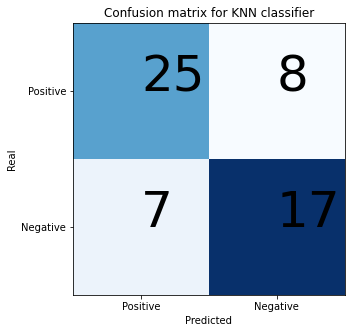

KNN precision:  78.12 %
KNN recall:  75.76 %
KNN f1 score:  76.92 %
KNN false positive rate:  21.88 %
KNN false negative rate:  32.0 %


In [ ]:
# Analize knn results using confusion matrix
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score

knn_matrix = confusion_matrix(Y_test, knn.predict(X_test))
# Plot confusion matrix
def plot_conf_matrix(cm, model_name):
    plt.figure(figsize=(5, 5))
    plt.title('Confusion matrix for '+model_name+' classifier')
    plt.imshow(cm, cmap=plt.cm.Blues)
    tick_marks = np.arange(2)
    plt.xticks(tick_marks, ['Positive', 'Negative'])
    plt.yticks(tick_marks, ['Positive', 'Negative'])
    plt.text(0, 0, cm[1][1], color='black', fontsize=50)
    plt.text(0, 1, cm[0][1], color='black', fontsize=50)
    plt.text(1, 0, cm[1][0], color='black', fontsize=50)
    plt.text(1, 1, cm[0][0], color='black', fontsize=50)
    plt.xlabel("Predicted")
    plt.ylabel("Real")
    plt.show()

plot_conf_matrix(knn_matrix, "KNN")
# Calculate precision, recall and f1 score
print("KNN precision: ", round(precision_score(Y_test, knn.predict(X_test))*100,2),"%")
print("KNN recall: ", round(recall_score(Y_test, knn.predict(X_test))*100,2),"%")
print("KNN f1 score: ", round(f1_score(Y_test, knn.predict(X_test))*100,2),"%")

# Calculate false positive rate and false negative rate
knn_fp_ratio = knn_matrix[0][1]/(knn_matrix[0][1]+knn_matrix[1][1])
knn_fn_ratio = knn_matrix[1][0]/(knn_matrix[1][0]+knn_matrix[0][0])
print("KNN false positive rate: ", round(knn_fp_ratio*100,2),"%")
print("KNN false negative rate: ", round(knn_fn_ratio*100,2),"%")

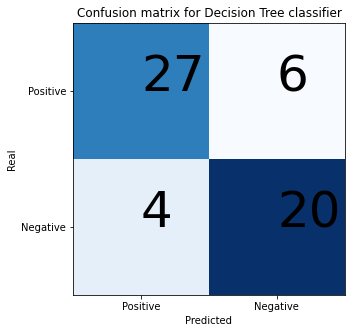

Decision Tree precision:  87.1 %
Decision Tree recall:  81.82 %
Decision Tree f1 score:  84.38 %
Decision Tree false positive rate:  12.9 %
Decision Tree false negative rate:  23.08 %


In [ ]:
# Analize tree results using confusion matrix
tree_matrix = confusion_matrix(Y_test, tree.predict(X_test))

# Plot confusion matrix
plot_conf_matrix(tree_matrix, "Decision Tree")

# Calculate precision, recall and f1 score
print("Decision Tree precision: ", round(precision_score(Y_test, tree.predict(X_test))*100,2),"%")
print("Decision Tree recall: ", round(recall_score(Y_test, tree.predict(X_test))*100,2),"%")
print("Decision Tree f1 score: ", round(f1_score(Y_test, tree.predict(X_test))*100,2),"%")

# Calculate false positive rate and false negative rate
tree_fp_ratio = tree_matrix[0][1]/(tree_matrix[0][1]+tree_matrix[1][1])
tree_fn_ratio = tree_matrix[1][0]/(tree_matrix[1][0]+tree_matrix[0][0])
print("Decision Tree false positive rate: ", round(tree_fp_ratio*100,2),"%")
print("Decision Tree false negative rate: ", round(tree_fn_ratio*100,2),"%")


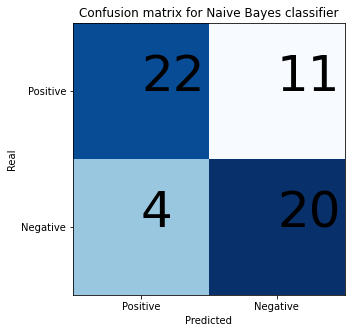

Naive Bayes precision:  84.62 %
Naive Bayes recall:  66.67 %
Naive Bayes f1 score:  74.58 %
Naive Bayes false positive rate:  15.38 %
Naive Bayes false negative rate:  35.48 %


In [ ]:
# Analize bayes results using confusion matrix
bayes_matrix = confusion_matrix(Y_test, bayes.predict(X_test))

# Plot confusion matrix
plot_conf_matrix(bayes_matrix, "Naive Bayes")

# Calculate precision, recall and f1 score
print("Naive Bayes precision: ", round(precision_score(Y_test, bayes.predict(X_test))*100,2),"%")
print("Naive Bayes recall: ", round(recall_score(Y_test, bayes.predict(X_test))*100,2),"%")
print("Naive Bayes f1 score: ", round(f1_score(Y_test, bayes.predict(X_test))*100,2),"%")

# Calculate false positive rate and false negative rate
bayes_fp_ratio = bayes_matrix[0][1]/(bayes_matrix[0][1]+bayes_matrix[1][1])
bayes_fn_ratio = bayes_matrix[1][0]/(bayes_matrix[1][0]+bayes_matrix[0][0])
print("Naive Bayes false positive rate: ", round(bayes_fp_ratio*100,2),"%")
print("Naive Bayes false negative rate: ", round(bayes_fn_ratio*100,2),"%")


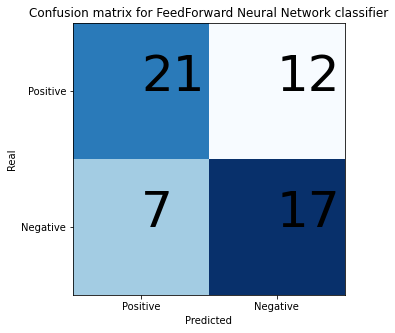

FeedForward Neural Network precision:  75.0 %
FeedForward Neural Network recall:  63.64 %
FeedForward Neural Network f1 score:  68.85 %
FeedForward Neural Network false positive rate:  25.0 %
FeedForward Neural Network false negative rate:  41.38 %


In [ ]:
# Analize ann results using confusion matrix
ann_pred = ann.predict(X_test)
ann_matrix = confusion_matrix(Y_test, ann_pred)

# Plot confusion matrix
plot_conf_matrix(ann_matrix, "FeedForward Neural Network")

# Calculate precision, recall and f1 score
print("FeedForward Neural Network precision: ", round(precision_score(Y_test, ann_pred)*100,2),"%")
print("FeedForward Neural Network recall: ", round(recall_score(Y_test, ann_pred)*100,2),"%")
print("FeedForward Neural Network f1 score: ", round(f1_score(Y_test, ann_pred)*100,2),"%")

# Calculate false positive rate and false negative rate
ann_fp_ratio = ann_matrix[0][1]/(ann_matrix[0][1]+ann_matrix[1][1])
ann_fn_ratio = ann_matrix[1][0]/(ann_matrix[1][0]+ann_matrix[0][0])
print("FeedForward Neural Network false positive rate: ", round(ann_fp_ratio*100,2),"%")
print("FeedForward Neural Network false negative rate: ", round(ann_fn_ratio*100,2),"%")

6. Empleando  el  conjunto de  validación indicar  si la  elección  realizada anteriormente  es  consistente  explicando,  en  caso  positivo  o  negativo los resultados  obtenidos  y  las  posibles  mejoras  al  procedimiento.(1  punto,  10 líneas máximo)

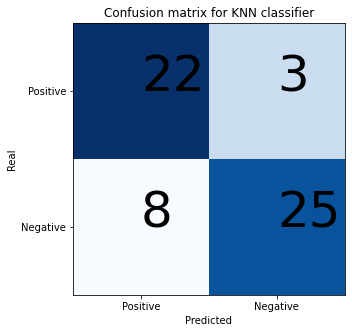

KNN precision:  73.33 %
KNN recall:  88.0 %
KNN f1 score:  80.0 %
KNN false positive rate:  26.67 %
KNN false negative rate:  10.71 %


In [ ]:
# Test knn model against validation set
knn_pred = knn.predict(X_val)
knn_matrix = confusion_matrix(Y_val, knn_pred)

# Plot confusion matrix
plot_conf_matrix(knn_matrix, "KNN")

# Calculate precision, recall and f1 score
print("KNN precision: ", round(precision_score(Y_val, knn_pred)*100,2),"%")
print("KNN recall: ", round(recall_score(Y_val, knn_pred)*100,2),"%")
print("KNN f1 score: ", round(f1_score(Y_val, knn_pred)*100,2),"%")

# Calculate false positive rate and false negative rate
knn_fp_ratio = knn_matrix[0][1]/(knn_matrix[0][1]+knn_matrix[1][1])
knn_fn_ratio = knn_matrix[1][0]/(knn_matrix[1][0]+knn_matrix[0][0])
print("KNN false positive rate: ", round(knn_fp_ratio*100,2),"%")
print("KNN false negative rate: ", round(knn_fn_ratio*100,2),"%")


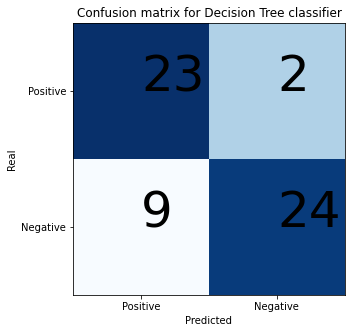

Decision Tree precision:  71.88 %
Decision Tree recall:  92.0 %
Decision Tree f1 score:  80.7 %
Decision Tree false positive rate:  28.12 %
Decision Tree false negative rate:  7.69 %


In [ ]:
# Test tree model against validation set
tree_pred = tree.predict(X_val)
tree_matrix = confusion_matrix(Y_val, tree_pred)

# Plot confusion matrix
plot_conf_matrix(tree_matrix, "Decision Tree")

# Calculate precision, recall and f1 score
print("Decision Tree precision: ", round(precision_score(Y_val, tree_pred)*100,2),"%")
print("Decision Tree recall: ", round(recall_score(Y_val, tree_pred)*100,2),"%")
print("Decision Tree f1 score: ", round(f1_score(Y_val, tree_pred)*100,2),"%")

# Calculate false positive rate and false negative rate
tree_fp_ratio = tree_matrix[0][1]/(tree_matrix[0][1]+tree_matrix[1][1])
tree_fn_ratio = tree_matrix[1][0]/(tree_matrix[1][0]+tree_matrix[0][0])
print("Decision Tree false positive rate: ", round(tree_fp_ratio*100,2),"%")
print("Decision Tree false negative rate: ", round(tree_fn_ratio*100,2),"%")


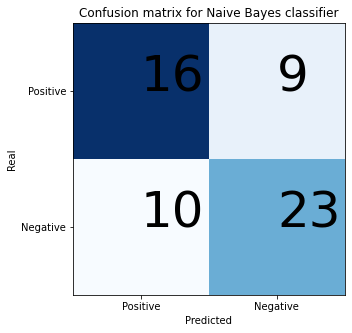

Naive Bayes precision:  61.54 %
Naive Bayes recall:  64.0 %
Naive Bayes f1 score:  62.75 %
Naive Bayes false positive rate:  38.46 %
Naive Bayes false negative rate:  28.12 %


In [ ]:
# Test bayes model against validation set
bayes_pred = bayes.predict(X_val)
bayes_matrix = confusion_matrix(Y_val, bayes_pred)

# Plot confusion matrix
plot_conf_matrix(bayes_matrix, "Naive Bayes")

# Calculate precision, recall and f1 score
print("Naive Bayes precision: ", round(precision_score(Y_val, bayes_pred)*100,2),"%")
print("Naive Bayes recall: ", round(recall_score(Y_val, bayes_pred)*100,2),"%")
print("Naive Bayes f1 score: ", round(f1_score(Y_val, bayes_pred)*100,2),"%")

# Calculate false positive rate and false negative rate
bayes_fp_ratio = bayes_matrix[0][1]/(bayes_matrix[0][1]+bayes_matrix[1][1])
bayes_fn_ratio = bayes_matrix[1][0]/(bayes_matrix[1][0]+bayes_matrix[0][0])
print("Naive Bayes false positive rate: ", round(bayes_fp_ratio*100,2),"%")
print("Naive Bayes false negative rate: ", round(bayes_fn_ratio*100,2),"%")

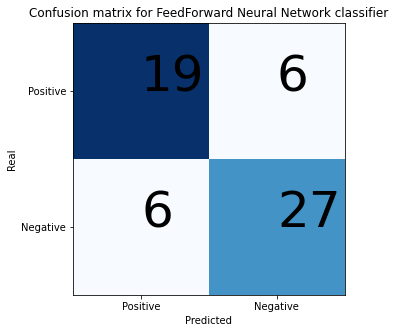

FeedForward Neural Network precision:  76.0 %
FeedForward Neural Network recall:  76.0 %
FeedForward Neural Network f1 score:  76.0 %
FeedForward Neural Network false positive rate:  24.0 %
FeedForward Neural Network false negative rate:  18.18 %


In [ ]:
# Test ann model against validation set
ann_pred = ann.predict(X_val)
ann_matrix = confusion_matrix(Y_val, ann_pred)

# Plot confusion matrix
plot_conf_matrix(ann_matrix, "FeedForward Neural Network")

# Calculate precision, recall and f1 score
print("FeedForward Neural Network precision: ", round(precision_score(Y_val, ann_pred)*100,2),"%")
print("FeedForward Neural Network recall: ", round(recall_score(Y_val, ann_pred)*100,2),"%")
print("FeedForward Neural Network f1 score: ", round(f1_score(Y_val, ann_pred)*100,2),"%")

# Calculate false positive rate and false negative rate
ann_fp_ratio = ann_matrix[0][1]/(ann_matrix[0][1]+ann_matrix[1][1])
ann_fn_ratio = ann_matrix[1][0]/(ann_matrix[1][0]+ann_matrix[0][0])
print("FeedForward Neural Network false positive rate: ", round(ann_fp_ratio*100,2),"%")
print("FeedForward Neural Network false negative rate: ", round(ann_fn_ratio*100,2),"%")


7. Emplear un modelo lineal considerando las características del problema dado (no continuidad de la variable objetivo) y empleando algún criterio de selección de  parámetros óptimos necesariamente explicado  en  case.  Comparar  los resultados  con  el  modelo óptimo  seleccionado considerando  las  métricas propuestas anteriormente(1 punto, 10 líneas máximo).

(10,) (57, 10)


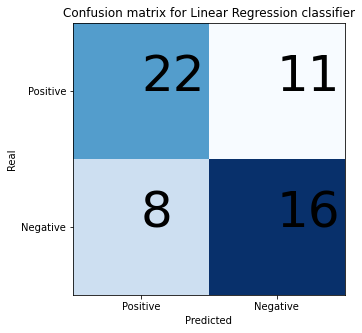

Linear Regression precision:  73.33 %
Linear Regression recall:  66.67 %
Linear Regression f1 score:  69.84 %
Linear Regression false positive rate:  26.67 %
Linear Regression false negative rate:  40.74 %


In [ ]:
# Create Linear model
X_train = np.array(X_train)
Y_train = np.array(Y_train)
X_test = np.array(X_test)
Y_test = np.array(Y_test)
X_val = np.array(X_val)
Y_val = np.array(Y_val)

# Obtain parameters for linear regression
params = np.linalg.inv(X_train.T @ X_train) @ X_train.T @ Y_train

print(params.shape, X_test.shape)

# Test linear model against test set
linear_pred = X_test @ params
mean = np.mean(linear_pred)
linear_pred[linear_pred < mean] = 0
linear_pred[linear_pred >= mean] = 1
linear_matrix = confusion_matrix(Y_test, linear_pred)

# Plot confusion matrix
plot_conf_matrix(linear_matrix, "Linear Regression")

# Calculate precision, recall and f1 score
print("Linear Regression precision: ", round(precision_score(Y_test, linear_pred)*100,2),"%")
print("Linear Regression recall: ", round(recall_score(Y_test, linear_pred)*100,2),"%")
print("Linear Regression f1 score: ", round(f1_score(Y_test, linear_pred)*100,2),"%")

# Calculate false positive rate and false negative rate
linear_fp_ratio = linear_matrix[0][1]/(linear_matrix[0][1]+linear_matrix[1][1])
linear_fn_ratio = linear_matrix[1][0]/(linear_matrix[1][0]+linear_matrix[0][0])
print("Linear Regression false positive rate: ", round(linear_fp_ratio*100,2),"%")
print("Linear Regression false negative rate: ", round(linear_fn_ratio*100,2),"%")

